# 자연어처리 튜토리얼 & 과제
이번 튜토리얼 및 과제에서는 자연어처리(NLP)와 관련된 전처리 및 모델을 간단하게 다뤄보겠습니다.<br>
튜토리얼에서는 https://www.kaggle.com/uciml/sms-spam-collection-dataset 에 있는 spam 분류 영어 데이터셋을 활용하겠습니다.<br>
과제에서 다룰 데이터는 https://github.com/e9t/nsmc/ 에서 받을 수 있는 영화 리뷰 데이터로 한글 데이터셋입니다.

[Tutorial]<br>
- NLP를 진행하기 위해 다음과 같은 라이브러리 함수들을 import합니다.

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline
import re
import json
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from konlpy.tag import Okt
import urllib.request

- spam.csv 파일을 spam이란 이름으로 불러오고 head() 함수를 활용해 데이터를 확인해봅시다.

In [2]:
spam = pd.read_csv('spam.csv', encoding='latin1')
spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


- 위에서 'v1'은 spam 메일 여부, 'v2'는 메일 내용, 나머지 뒤 3개의 열은 필요없는 것을 확인할 수 있습니다.<br>
- 뒤 3개의 열을 제거해주고 'v1'열의 data들을 숫자 0,1의 binary variable로 바꿔줍시다.(ham=0, spam=1)

In [3]:
del spam['Unnamed: 2']
del spam['Unnamed: 3']
del spam['Unnamed: 4']
spam['v1'] = spam['v1'].replace(['ham','spam'],[0,1])
spam[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


- v2 열에는 중복된 내용이 있을 수도 있고 이는 학습에 방해되므로 중복 데이터를 찾아내 제거해줍시다.<br>
- 이후 총 데이터 수를 확인해봅시다.

In [4]:
spam.drop_duplicates(subset=['v2'],inplace=True)
print('총 샘플의 수 :',len(spam))

총 샘플의 수 : 5169


- Label에 따른 데이터의 수를 확인해 너무 편향되어 있지는 않은지 확인하는 작업이 필요합니다.

   v1  count
0   0   4516
1   1    653


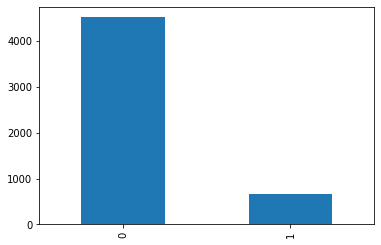

In [5]:
spam['v1'].value_counts().plot(kind='bar')
print(spam.groupby('v1').size().reset_index(name='count'))

- 위의 결과를 통해 1(spam)이 0(ham)보다 상당히 작은 것을 알 수 있지만 tutorial에서는 그냥 진행하도록 하겠습니다.<br>
- NLP에서는 데이터 별 문장 길이와 단어 길이를 아는 것이 중요하므로 이에 대한 데이터 탐색을 진행해봅시다.<br>
- 우선 데이터 별 문장 길이를 확인해보겠습니다.

In [6]:
spam_length = spam['v2'].astype(str).apply(len)
spam_length.head()

0    111
1     29
2    155
3     49
4     61
Name: v2, dtype: int64

- 문장 길이에 대한 histogram, box plot 그리고 정확한 수치들을 다음과 같이 구해볼 수 있습니다.

Text(0, 0.5, 'Number of mail')

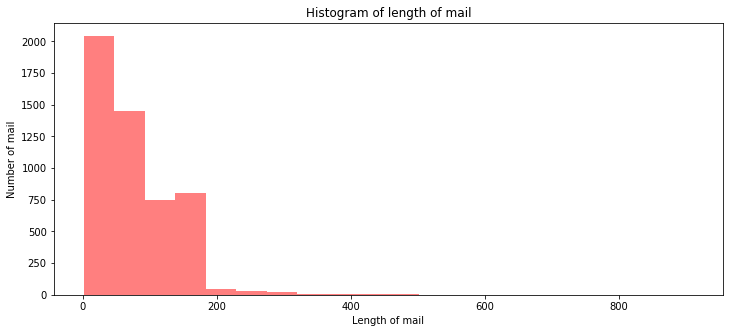

In [7]:
plt.figure(figsize=(12, 5))
plt.hist(spam_length, bins=20, alpha=0.5, color= 'r', label='word')
plt.title('Histogram of length of mail')
plt.xlabel('Length of mail')
plt.ylabel('Number of mail')

In [8]:
print('메일 길이 평균 값: {:.2f}'.format(np.mean(spam_length)))
print('메일 길이 제 1 사분위: {}'.format(np.percentile(spam_length, 25)))
print('메일 길이 제 3 사분위: {}'.format(np.percentile(spam_length, 75)))
print('메일 길이 제 3 사분위: {}'.format(np.max(spam_length)))

메일 길이 평균 값: 78.98
메일 길이 제 1 사분위: 36.0
메일 길이 제 3 사분위: 117.0
메일 길이 제 3 사분위: 910


{'whiskers': [<matplotlib.lines.Line2D at 0x132cee0668>,
 'caps': [<matplotlib.lines.Line2D at 0x132cee0cf8>,
 'boxes': [<matplotlib.lines.Line2D at 0x132cee0438>],
 'medians': [<matplotlib.lines.Line2D at 0x132ceef3c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x132ceefa20>],
 'means': [<matplotlib.lines.Line2D at 0x132ceef710>]}

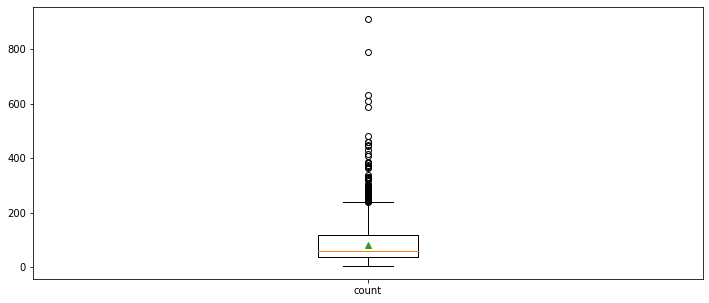

In [9]:
plt.figure(figsize=(12, 5))

plt.boxplot(spam_length, labels=['count'], showmeans=True)

- 이제 데이터 내 문장 별 단어 수에 대해서도 위와 같은 방법으로 탐색하는 작업을 진행합니다.<br>
- Histogram에서는 데이터간 차이를 잘 보여주기 위해 yscale을 log로 진행하였습니다.

In [10]:
spam_word_counts = spam['v2'].astype(str).apply(lambda x:len(x.split(' ')))
spam_word_counts

0       20
1        6
2       28
3       11
4       13
        ..
5567    30
5568     8
5569    10
5570    26
5571     6
Name: v2, Length: 5169, dtype: int64

Text(0, 0.5, 'Number of reviews')

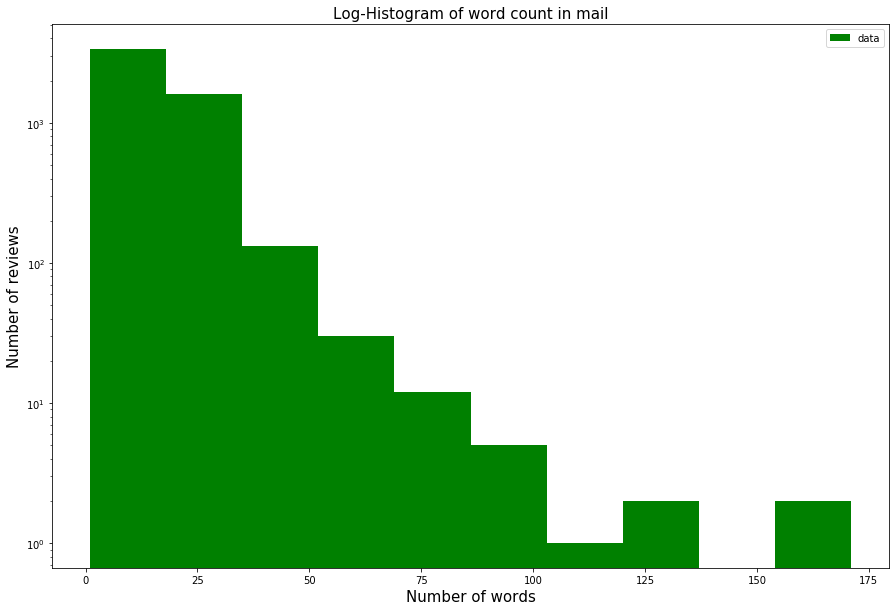

In [11]:
plt.figure(figsize=(15, 10))
plt.hist(spam_word_counts, bins=10, facecolor='g',label='data')
plt.title('Log-Histogram of word count in mail', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of reviews', fontsize=15)

In [12]:
print('메일 길이 평균 값: {:.2f}'.format(np.mean(spam_word_counts)))
print('메일 길이 제 1 사분위: {}'.format(np.percentile(spam_word_counts, 25)))
print('메일 길이 제 3 사분위: {}'.format(np.percentile(spam_word_counts, 75)))

메일 길이 평균 값: 15.46
메일 길이 제 1 사분위: 7.0
메일 길이 제 3 사분위: 22.0


- 이제 본격적인 전처리 과정을 진행해봅시다. <br>
- 우선 영어에 관한 데이터이기 때문에 다른 언어가 포함되지 않도록 알파벳만 남기고 나머지를 지우는 작업을 거칩니다.<br>
- 특수문자도 같이 지워지는 문제가 있지만 여기서는 이를 고려하지 않고 지우도록 하겠습니다.

In [13]:
spam['v2'] = spam['v2'].str.replace("[^a-zA-Z ]","")
spam['v2'].head()

0    Go until jurong point crazy Available only in ...
1                              Ok lar Joking wif u oni
2    Free entry in  a wkly comp to win FA Cup final...
3          U dun say so early hor U c already then say
4    Nah I dont think he goes to usf he lives aroun...
Name: v2, dtype: object

- 위의 과정을 통해 빈 내용을 갖는 행이 생겼을 수 있으므로 이를 파악하고 제거해줍시다.

In [14]:
spam['v2'].replace('', np.nan, inplace=True)
print(spam['v2'].isnull().sum())

1


In [15]:
spam = spam.dropna(how = 'any')
print(len(spam['v2']))

5168


- 이제 데이터를 X_data, y_data로 나눠줍시다.

In [16]:
X_data = spam['v2']
y_data = spam['v1']
X_data.head()

0    Go until jurong point crazy Available only in ...
1                              Ok lar Joking wif u oni
2    Free entry in  a wkly comp to win FA Cup final...
3          U dun say so early hor U c already then say
4    Nah I dont think he goes to usf he lives aroun...
Name: v2, dtype: object

- Tokenizer() 함수를 활용해 토큰화를 진행합니다. <br>
- 이 과정을 통해 단어들이 숫자로 치환되고 원래 문장을 숫자들의 순서로 배열하여 표현할 수 있습니다.(sequences_spam)

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)
sequences_spam = tokenizer.texts_to_sequences(X_data)

In [18]:
print(sequences_spam[:5])

[[42, 406, 3574, 716, 650, 686, 63, 8, 1109, 92, 116, 457, 932, 143, 2458, 1110, 66, 54, 3575, 131], [49, 281, 1251, 407, 6, 1614], [52, 501, 8, 4, 933, 934, 2, 208, 2459, 1111, 651, 2460, 267, 268, 69, 2459, 2, 2, 331, 501, 3576, 82, 3577, 408, 3578], [6, 209, 144, 23, 322, 2461, 6, 154, 134, 56, 144], [862, 1, 43, 86, 68, 419, 2, 811, 68, 1615, 186, 101, 420]]


- indexing된 숫자들이 어떤 단어를 의미하는지 단어사전을 알고싶다면 아래와 같은 코드를 이용하면 됩니다.

In [19]:
word_to_index = tokenizer.word_index
print(word_to_index)

{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'my': 11, 'for': 12, 'your': 13, 'it': 14, 'of': 15, 'have': 16, 'that': 17, 'on': 18, 'call': 19, 'are': 20, 'im': 21, 'now': 22, 'so': 23, 'but': 24, 'not': 25, 'at': 26, 'can': 27, 'or': 28, 'be': 29, 'do': 30, 'get': 31, 'will': 32, 'with': 33, 'just': 34, 'if': 35, 'we': 36, 'no': 37, 'ur': 38, 'this': 39, 'up': 40, 'its': 41, 'go': 42, 'dont': 43, 'from': 44, 'when': 45, 'how': 46, 'ltgt': 47, 'out': 48, 'ok': 49, 'all': 50, 'what': 51, 'free': 52, 'know': 53, 'got': 54, 'like': 55, 'then': 56, 'good': 57, 'am': 58, 'ill': 59, 'was': 60, 'come': 61, 'time': 62, 'only': 63, 'day': 64, 'want': 65, 'there': 66, 'love': 67, 'he': 68, 'text': 69, 'send': 70, 'going': 71, 'one': 72, 'need': 73, 'by': 74, 'lor': 75, 'as': 76, 'home': 77, 'about': 78, 'see': 79, 'back': 80, 'still': 81, 'txt': 82, 'stop': 83, 'r': 84, 'our': 85, 'think': 86, 'well': 87, 'today': 88, 'reply': 89, 'tell': 90, 'hi': 

- 단어 집합의 크기를 확인할 때는 +1을 해주는데 이 이유는 문장 길이를 동일하게 해줄 때 필요한 padding을 사전에 추가로 넣기 때문입니다. <br> 
- 그래서 총 단어집합의 크기가 8540이 된 것을 확인할 수 있습니다.

In [20]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 8540


- 전처리 작업이 끝난 이후의 메일 내 단어 길이를 한 번 더 확인해봅시다.

메일의 단어 최대 길이 : 171
메일의 단어 평균 길이 : 14.655186


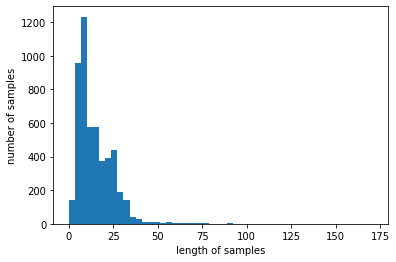

In [21]:
X_data = sequences_spam
print('메일의 단어 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 단어 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 모든 문장들을 하나의 크기로 일치시켜주는 작업이 필요하고(padding 작업) 여기서는 문장 최대 길이였던 171로 두겠습니다. <br>
- 이 과정을 거친 후 X_data 하나를 보면 기존 sequence 이외의 부분은 0 padding으로 채워진 것을 확인할 수 있습니다.

In [22]:
max_len = 171
X_data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", X_data.shape)

훈련 데이터의 크기(shape):  (5168, 171)


In [23]:
X_data[50]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

- 이후 데이터를 훈련용 데이터, 평가용 데이터로 나누고 모델링을 진행하면 됩니다. <br>
- 모델은 과제 파트에서 같이 다루도록 하겠습니다.

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)

[과제] <br>
- 우선 naver.txt를 read_csv로 읽어옵니다. 이 때, delimiter는 '\t'가 되고 header를 0으로 지정해주어야 합니다. <br>
- head함수를 활용해 5개의 데이터를 읽어봅시다.

In [25]:
data=pd.read_csv(___________________________)
data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


- 학습 속도를 높이기 위해 데이터를 10000개만 활용하도록 하겠습니다.

In [26]:
data = data.iloc[:10000,]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        10000 non-null  int64 
 1   document  9998 non-null   object
 2   label     10000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 234.5+ KB


- 데이터 내에서 중복되는 데이터가 있는지 확인해보고 중복데이터를 제거해주세요.

In [27]:
_________________________________________
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 9913


- 라벨에 따른 데이터 수를 bar chart를 통해 알아보고 구체적인 수를 확인해주세요.

   label  count
0      0   4896
1      1   5017


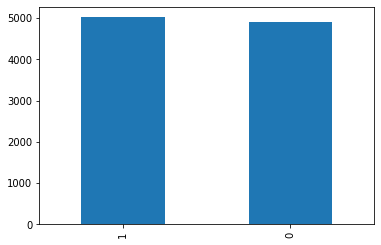

In [28]:
__________________________________
print(data.groupby_______________.reset_index(name='count'))

- 리뷰 별 글자수를 파악해보겠습니다. data_length에 리뷰의 글자수들을 저장해주세요.

In [29]:
data_length = ____________________________
data_length.head()

0     3
1    20
2    38
3    32
4    49
Name: document, dtype: int64

- 리뷰 길이에 대한 histogram을 그려주세요. <br>
- 이 때, 색깔은 blue, bins= 20으로 진행해주세요.

Text(0, 0.5, 'Number of answer')

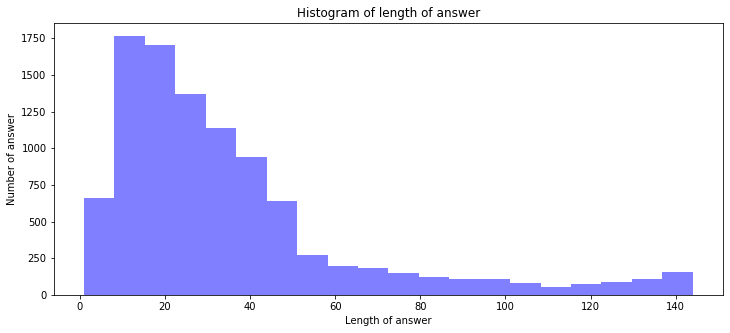

In [30]:
plt.figure(figsize=(12, 5))
plt.hist(__________, ___________, alpha=0.5, __________, label='word')
plt.title('Histogram of length of answer')
plt.xlabel('Length of answer')
plt.ylabel('Number of answer')

- 위 리뷰 길이에 대해서 좀 더 정확한 수치를 파악해보겠습니다. <br>
- 리뷰 길이에 대해 최대, 최소, 평균, 1사분위, 3사분위 값을 확인해주세요. <br>

In [31]:
print('리뷰 길이 최대 값: {}'.______________________)
print('리뷰 길이 최소 값: {}'.______________________)
print('리뷰 길이 평균 값: {:.2f}'.______________________)
print('리뷰 길이 제 1 사분위: {}'.______________________)
print('리뷰 길이 제 3 사분위: {}'.______________________)

리뷰 길이 최대 값: 144
리뷰 길이 최소 값: 1
리뷰 길이 평균 값: 35.19
리뷰 길이 제 1 사분위: 16.0
리뷰 길이 제 3 사분위: 42.0


- 이제 문장 내 단어의 수에 대해 파악해보겠습니다. <br>
- data_word_counts에 문장 내 단어 수를 저장해주세요.

In [32]:
data_word_counts = ____________________________________________

- 앞서 문장 길이에서 보았던 것처럼 histogram과 정확한 수치를 확인해주세요.<br>
- Histogram에서 bins는 10, color는 green으로 진행해주세요. 또한 차이를 잘 파악하기 위해 yscale을 로그로 진행해주세요.<br>
- 정확한 수치 파악은 앞과 같이 최대, 최소, 평균, 1사분위, 3사분위 값을 구해주세요. <br>

Text(0, 0.5, 'Number of reviews')

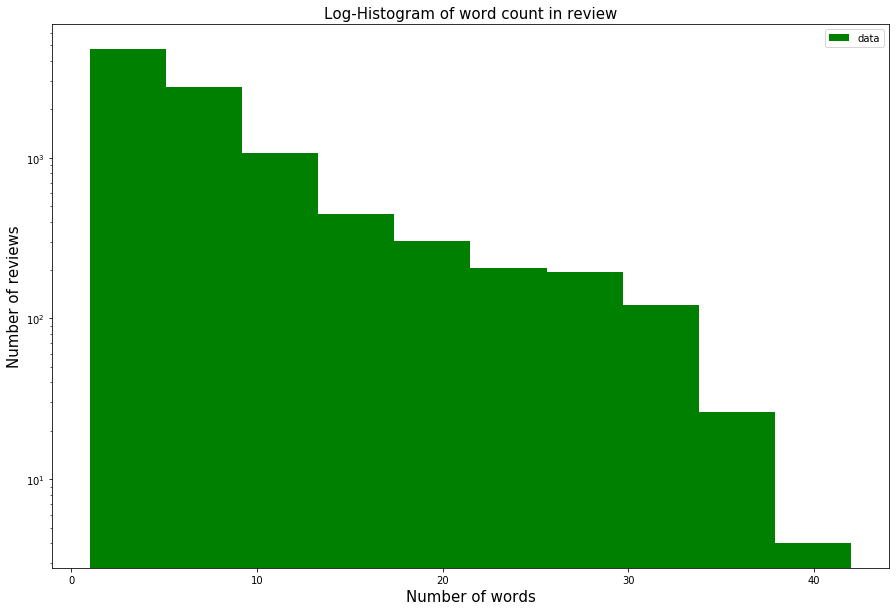

In [33]:
plt.figure(figsize=(15, 10))
plt.hist(_________________________,label='data')
plt.title('Log-Histogram of word count in review', fontsize=15)
plt.________________________
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of reviews', fontsize=15)

In [34]:
print('리뷰 당 단어길이 최대 값: {}'.________________________)
print('리뷰 당 단어길이 최소 값: {}'.________________________)
print('리뷰 당 단어길이 평균 값: {:.2f}'.________________________)
print('리뷰 당 단어길이 제 1 사분위: {}'.________________________)
print('리뷰 당 단어길이 제 3 사분위: {}'.________________________)

리뷰 당 단어길이 최대 값: 42
리뷰 당 단어길이 최소 값: 1
리뷰 당 단어길이 평균 값: 7.57
리뷰 당 단어길이 제 1 사분위: 3.0
리뷰 당 단어길이 제 3 사분위: 9.0


- 튜토리얼에서 봤던 것처럼 한글을 제외한 알파벳, 특수기호들을 전부 제거해주세요.

In [35]:
data['document'] = data['document']___________("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


- 공백이 생긴 데이터를 NA로 바꿔주고 이를 데이터에서 제거해주세요.<br>
- 이후 데이터의 수를 확인해봅니다.

In [36]:
__________________________________
data = data.____________________
print(len(data))

9860


- 한글 데이터는 영어 데이터와 달리 조사 등의 불용어를 제거해주는 작업이 필요합니다. <br>
- Okt 함수를 활용해 진행하게 되면 시간이 좀 걸리니 결과가 바로 뜨지 않아도 오류가 아닙니다!

In [37]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [38]:
okt=Okt()
X = []
for sentence in data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X.append(temp_X)

C:\anaconda\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [39]:
X[:3]

[['굳다', 'ㅋ'],
 ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]

- Tokenizer를 활용해 토큰화를 진행해주시고 X에 토큰화된 단어 인덱스들을 저장해주세요. <br>
- y에는 label 데이터를 저장해주세요.

In [40]:
tokenizer = ____________
tokenizer.__________________
X = tokenizer._______________________
X[:5]

[[609, 94],
 [65, 143, 24, 346, 18, 16, 300, 687, 40, 917, 20],
 [60, 18, 78, 367, 100, 96, 50, 130, 223],
 [14, 20, 106, 1977, 101, 50, 37, 21, 23, 165, 5841, 774],
 [326, 2225, 13, 29, 326, 1]]

In [41]:
y = ______________________
y[:5]

array([1, 0, 0, 0, 1], dtype=int64)

- 단어 사전 크기를 정의해주세요. <br>
- 이후 padding을 진행해주세요. (문장 최대 길이는 30) <br>
- x와 y를 test, train 데이터로 분리해주세요. (test_size = 0.3)

In [42]:
vocab_size = _________________________

In [44]:
max_len = __
X = ____________________________
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,  609,   94],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   65,  143,   24,
         346,   18,   16,  300,  687,   40,  917,   20],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   60,
          18,   78,  367,  100,   96,   50,  130,  223],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   14,   20,  106, 1977,
         101,   50,   37,   21,   23,  165, 5841,  774],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  326, 2225, 

In [45]:
x_train, x_test, y_train, y_test = _______________________________

# RNN Model

- 기본적인 RNN 모델을 진행해보겠습니다. <br>
- 다음과 같은 라이브러리가 필요합니다.

In [46]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

- 이제 RNN 모델을 적용시켜보도록 하겠습니다. 가장 간단한 구조로 임베딩 셀, 기본 RNN 셀, 출력셀로 구성되어 있습니다.<br>
- Embedding층에서는 입력을 단어 사전의 크기로 받고 32차원의 임베딩 벡터를 출력합니다. <br>
- 마지막 dense에서는 1개의 출력을 내보내며 활성화함수로 sigmoid함수를 사용했습니다. <br>
- 이후 compile 함수를 통해 층들을 합쳐주고 optimizer과 loss를 지정해주었습니다. <br>
- history1에서 모델을 학습하는 작업이 진행되며 총 4회 반복 진행했으며 batch_size = 64, validation_split은 0.2입니다.

In [47]:
model1 = Sequential()
model1.add(Embedding(vocab_size, 32))
model1.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history1 = model1.fit(x_train, y_train, epochs=4, batch_size=64, validation_split=0.2)

Train on 5521 samples, validate on 1381 samples
Epoch 1/4
5521/5521 [==============================] - 8s 1ms/sample - loss: 0.6682 - acc: 0.5975 - val_loss: 0.6079 - val_acc: 0.7038
Epoch 2/4
5521/5521 [==============================] - 2s 436us/sample - loss: 0.4720 - acc: 0.7988 - val_loss: 0.5267 - val_acc: 0.7314
Epoch 3/4
5521/5521 [==============================] - 2s 395us/sample - loss: 0.3030 - acc: 0.8810 - val_loss: 0.5453 - val_acc: 0.7386
Epoch 4/4
5521/5521 [==============================] - 2s 409us/sample - loss: 0.1964 - acc: 0.9315 - val_loss: 0.5675 - val_acc: 0.7531


- x_test와 y_test에 대해서 평가를 진행해봅니다. 정확도가 0.7759인 것을 알 수 있습니다.

In [48]:
print(model1.evaluate(x_test, y_test)[1])

2958/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# LSTM Model

- LSTM Model을 만들 때 쓰이는 함수들을 import합니다.

In [49]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

- model2에 임베딩 셀, LSTM 셀 1개, 출력셀을 추가해주세요. <br>
- 임베딩 셀에서 출력 차원은 100, LSTM에서 hidden size 크기는 128로 해주세요. <br>
- 출력셀에서 활성화 함수는 sigmoid를 사용해주세요.<br>
- 이후 history2에 모델을 학습시켜주세요(5회 반복, batch 크기는 60, validation 비율은 0.3) <br>

In [50]:
model2 = ________________
model2.add(__________________)
model2.add(___________)
model2.add(_____________________________)

model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history2 = _________________________________________________________

Train on 5521 samples, validate on 1381 samples
Epoch 1/5
5521/5521 [==============================] - 19s 3ms/sample - loss: 0.5799 - acc: 0.6939 - val_loss: 0.4876 - val_acc: 0.7741
Epoch 2/5
5521/5521 [==============================] - 13s 2ms/sample - loss: 0.3697 - acc: 0.8384 - val_loss: 0.4685 - val_acc: 0.8030
Epoch 3/5
5521/5521 [==============================] - 13s 2ms/sample - loss: 0.2864 - acc: 0.8843 - val_loss: 0.4895 - val_acc: 0.8001
Epoch 4/5
5521/5521 [==============================] - 12s 2ms/sample - loss: 0.2490 - acc: 0.9049 - val_loss: 0.5203 - val_acc: 0.7965
Epoch 5/5
5521/5521 [==============================] - 13s 2ms/sample - loss: 0.2053 - acc: 0.9219 - val_loss: 0.5415 - val_acc: 0.7936


- model2에 대해서 x,y_test에 대한 평가를 진행해주세요.

In [51]:
print(___________________________)

2958/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

# 수고하셨습니다!!